In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
import heapq
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Step 1

Find a dataset with:
* Sensitive attributes
* A target variable to train a classifier on

Examples:
* Adults [Gender, Income]
* COMPAS [RACE, ScoreText]
* German Credit Dataset [Gender, Creditability] (https://online.stat.psu.edu/stat857/node/222/)
* Student Dropout [Gender / Nationality, Whether Dropout or not] (https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)
* Diabetes Dataset [Gender / Race, readmitted] (https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)

In [2]:
df = pd.read_csv("../datasets/diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
df.shape, df.columns

((101766, 50),
 Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
        'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
        'time_in_hospital', 'payer_code', 'medical_specialty',
        'num_lab_procedures', 'num_procedures', 'num_medications',
        'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
        'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
        'tolazamide', 'examide', 'citoglipton', 'insulin',
        'glyburide-metformin', 'glipizide-metformin',
        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
        'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
       dtype='object'))

In [4]:
df["readmitted"].value_counts() # Target

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [5]:
df["gender"].value_counts() # Sensitive Attr

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

Pre-process columns:
* Categorical
* Scale

Remove sensitive attribute.

### Adults

In [6]:
le = LabelEncoder()

adult_columns = [
    "race",
    "gender",
    "age",
    "weight",
    "medical_specialty",
    "max_glu_serum",
    "A1Cresult",
    "metformin",
    "repaglinide",
    "nateglinide",
    "chlorpropamide",
    "glimepiride",
    "acetohexamide",
    "glipizide",
    "glyburide",
    "tolbutamide",
    "pioglitazone",
    "rosiglitazone",
    "acarbose",
    "miglitol",
    "troglitazone",
    'tolazamide', 'examide', 'citoglipton', 'insulin',
    'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'diag_3', 'diag_1', 'diag_2'
]
# adults_drop = ["gender", "index"]
adults_drop = [
    "gender", 
    "readmitted", 
    "encounter_id", 
    "patient_nbr", 
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "payer_code",
    "index"
]

for col in adult_columns:
    df[col] = le.fit_transform(df[col])

new_df = df[df["gender"] == 0].sample(frac=0.3)
new_df = pd.concat((new_df, df[df["gender"] == 1]))
df = new_df.sample(frac=1)
df = df.reset_index()

s = df["gender"]
X = df.drop(columns=adults_drop)
y = df["readmitted"]

X.head()

,race,age,weight,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,3,7,1,6,4,35,0,16,0,0,...,0,0,1,1,0,0,0,0,0,1
1,3,6,1,6,12,84,2,24,0,0,...,0,0,3,1,0,0,0,0,0,1
2,3,8,1,3,0,45,4,13,0,0,...,0,0,1,1,0,0,0,0,1,0
3,3,6,1,4,9,10,0,17,0,0,...,0,0,1,1,0,0,0,0,0,1
4,1,7,1,5,0,31,2,20,0,0,...,0,0,2,1,0,0,0,0,1,1


### Final

In [7]:
X = StandardScaler().fit_transform(X)
X.shape, y.shape

((63467, 42), (63467,))

# Step 2

Train a classifier on the dataset:
* LogisticRegression
* Simple NN (MLP)
* Decision Tree

TODO: Split to train/test and check the test score instead of train score.

In [8]:
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, indices, test_size=0.3, random_state=0, shuffle=True, )
clf = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=0, max_iter=300, verbose=1).fit(X, y)
# clf = LogisticRegression(random_state=0).fit(X_train, y_train)
# clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

Iteration 1, loss = 0.91210473
Iteration 2, loss = 0.89417948
Iteration 3, loss = 0.89002099
Iteration 4, loss = 0.88625103
Iteration 5, loss = 0.88359817
Iteration 6, loss = 0.88099900
Iteration 7, loss = 0.87870299
Iteration 8, loss = 0.87589468
Iteration 9, loss = 0.87358428
Iteration 10, loss = 0.87112080
Iteration 11, loss = 0.86873616
Iteration 12, loss = 0.86633783
Iteration 13, loss = 0.86331937
Iteration 14, loss = 0.86058492
Iteration 15, loss = 0.85843599
Iteration 16, loss = 0.85565966
Iteration 17, loss = 0.85231768
Iteration 18, loss = 0.85022416
Iteration 19, loss = 0.84749690
Iteration 20, loss = 0.84487346
Iteration 21, loss = 0.84248976
Iteration 22, loss = 0.83981516
Iteration 23, loss = 0.83687129
Iteration 24, loss = 0.83449907
Iteration 25, loss = 0.83147409
Iteration 26, loss = 0.83049253
Iteration 27, loss = 0.82774512
Iteration 28, loss = 0.82497950
Iteration 29, loss = 0.82298509
Iteration 30, loss = 0.82137757
Iteration 31, loss = 0.81951851
Iteration 32, los

0.7077359382385379

Sort the points based on the accuracy of the classifier

In [9]:
scores = clf.predict_proba(X_test)[list(y_test.reset_index().index), y_test.to_list()]
scores.shape

(19041,)

In [10]:
BOTTOM_K_ERROR_REGION = 0.2 # The ratio of error region
ratio = int(BOTTOM_K_ERROR_REGION * len(scores))
err_region_ind = np.argpartition(scores, ratio)[:ratio]
err_region = scores[err_region_ind]
err_region.shape, scores.shape

((3808,), (19041,))

Visualize the error region in 2D

In [ ]:
pca = PCA(n_components=2)
x_test_reduced = pca.fit_transform(X_test)
y_test_reduced = np.zeros(y_test.shape)
y_test_reduced[err_region_ind] = 1
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x=x_test_reduced[:, 0], y=x_test_reduced[:, 1], c=y_test_reduced, s=4)
ax[0].set_title("Error region (Yellow is error region)")
ax[1].scatter(x=x_test_reduced[:, 0], y=x_test_reduced[:, 1], c=np.bitwise_not(s[ind_test]), s=4)
ax[1].set_title("Demographic groups (Yellow is minority)")

# Step 3
Find high skews

In [11]:
err_region_one_hot = np.zeros(y_test.shape)
err_region_one_hot[err_region_ind] = 1
np.unique(err_region_one_hot, return_counts=True)

(array([0., 1.]), array([15233,  3808]))

Approach

* Sample from the test data
* For each pair of points (a, b) in this sample, where a \in err_region and b \notin err_region calc skew
* Report highest skews

In [12]:
def skew(f, points):
    p_f = np.dot(points, f)
    mean = np.mean(p_f)
    sd = np.std(p_f)
    median = np.median(p_f)
    return ((mean - median) / sd)

def get_line(first_point, second_point):
    vec = second_point - first_point
    v_hat = vec / np.linalg.norm(vec)
    return v_hat

In [13]:
TEST_SAMPLE_RATIO = .05
X_test.shape, err_region_one_hot.shape

((19041, 42), (19041,))

In [14]:
ind_sample = np.random.choice(len(X_test), size=int(len(X_test) * TEST_SAMPLE_RATIO), replace=False)
sample_test = X_test[ind_sample]
sample_err = err_region_one_hot[ind_sample]
sample_test.shape, sample_err.shape, np.unique(sample_err, return_counts=True)

((952, 42), (952,), (array([0., 1.]), array([755, 197])))

In [15]:
def get_tail_ind(X_train, f, TAIL_PERCENTILE=0.2):
    tmp = np.dot(X_train, f)
    sk = (np.mean(tmp) - np.median(tmp)) / np.std(tmp)
    q1 = np.quantile(tmp, TAIL_PERCENTILE if sk < 0 else (1 - TAIL_PERCENTILE))
    tail_ind = np.apply_along_axis(lambda r: np.dot(r, f) < q1 if sk < 0 else np.dot(r, f) > q1, 1, X_train)
    return tail_ind

In [16]:
err_reg_portion = sample_test[sample_err == 1]
not_err_reg_portion = sample_test[sample_err == 0]

heap = []
counter = 0
MAX = len(err_reg_portion)

for a in err_reg_portion:
    counter += 1
    print(f"{counter} / {MAX}")
    for b in not_err_reg_portion:
        f = get_line(a, b)
        sk = skew(f, X_train)
        # tail_ind = get_tail_ind(X_train, f)
        # score = np.mean(clf.predict_proba(X_train[tail_ind])[list(y_train[tail_ind].reset_index().index), y_train[tail_ind].to_list()])
        # if score <= 0.7:
        heapq.heappush(heap, (-sk, tuple(f)))

1 / 197
2 / 197
3 / 197
4 / 197
5 / 197
6 / 197
7 / 197
8 / 197
9 / 197
10 / 197
11 / 197
12 / 197
13 / 197
14 / 197
15 / 197
16 / 197
17 / 197
18 / 197
19 / 197
20 / 197
21 / 197
22 / 197
23 / 197
24 / 197
25 / 197
26 / 197
27 / 197
28 / 197
29 / 197
30 / 197
31 / 197
32 / 197
33 / 197
34 / 197
35 / 197
36 / 197
37 / 197
38 / 197
39 / 197
40 / 197
41 / 197
42 / 197
43 / 197
44 / 197
45 / 197
46 / 197
47 / 197
48 / 197
49 / 197
50 / 197
51 / 197
52 / 197
53 / 197
54 / 197
55 / 197
56 / 197
57 / 197
58 / 197
59 / 197
60 / 197
61 / 197
62 / 197
63 / 197
64 / 197
65 / 197
66 / 197
67 / 197
68 / 197
69 / 197
70 / 197
71 / 197
72 / 197
73 / 197
74 / 197
75 / 197
76 / 197
77 / 197
78 / 197
79 / 197
80 / 197
81 / 197
82 / 197
83 / 197
84 / 197
85 / 197
86 / 197
87 / 197
88 / 197
89 / 197
90 / 197
91 / 197
92 / 197
93 / 197
94 / 197
95 / 197
96 / 197
97 / 197
98 / 197
99 / 197
100 / 197
101 / 197
102 / 197
103 / 197
104 / 197
105 / 197
106 / 197
107 / 197
108 / 197
109 / 197
110 / 197
111 / 19

In [17]:
def get_high_skews(heap, top_k=10):
        count = 0
        heap = heap.copy()
        while True:
            count = count + 1
            try:
                yield heapq.heappop(heap)
                if count == top_k:
                    break
            except:
                break

top_skews = list(get_high_skews(heap, top_k=5))

Visualize high skewed directions

In [18]:
gender = s[ind_train]

In [19]:
gender.value_counts()

gender
1    32920
0    11506
Name: count, dtype: int64

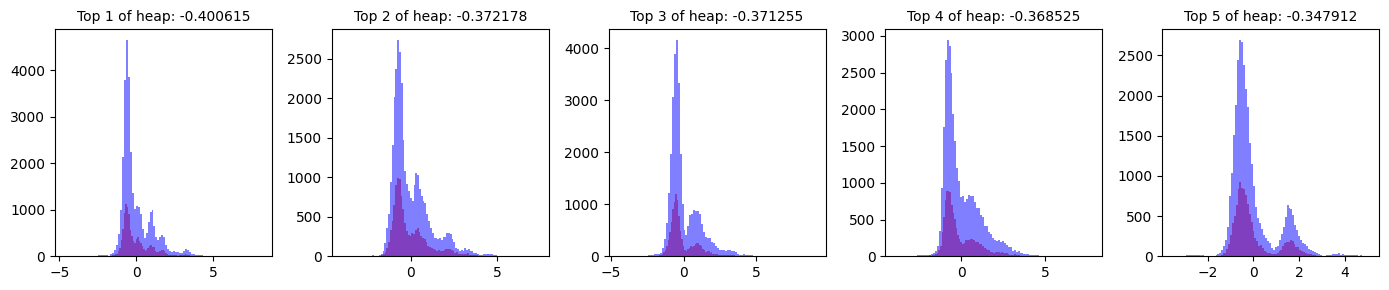

In [20]:
fig, axs = plt.subplots(1, len(top_skews), figsize=(14, 3))
ind = 0
fil = gender.apply(lambda x: x in [0])
for ax in axs:
    ax.hist(np.dot(X_train[fil], top_skews[ind][1]), color="red", alpha=0.5, bins=100, label="Female")
    ax.hist(np.dot(X_train[np.logical_not(fil)], top_skews[ind][1]), color="blue", alpha=0.5, bins=100, label="Male")
    ax.set_title(f"Top {ind + 1} of heap: {round(top_skews[ind][0], 6)}", fontsize=10)
    ind += 1
plt.tight_layout()

# Step 3

Report problematic points from the tail.

* Given a percentile as hyper-parameter, find the tail on X_train
* Among the points on the tail, report the most problematic ones

In [21]:
TAIL_PERCENTILE = 0.2 # Percentile of points as tail
SCORE_RATIO = 0.05 # Error region ratio in X_train

In [22]:
def get_demo_ratio(arr, *min):
    uniq, counts = np.unique(arr, return_counts=True)

    min_count = 0
    
    for m in min:
        try:
            min_count += counts[uniq == m][0]
        except:
            pass

    maj_count = 0
    try:
        maj_count = np.sum(counts)
    except:
        pass

    return min_count / max(maj_count, 0.1)

In [23]:
results = {
    "top_skew": [], # Which highest skew (1st, 2nd, ...)
    "total_demo_ratio": [], # Demographic ratio of minorities
    "tail_demo_ratio": [], # Demographic ratio of minorities on the tail
    "tail_percentile": [], # The percentile used as tail
    "min_avg_tail_score": [], # Average score of minorities on tail
    "maj_avg_tail_score": [], # Average score of majoroties on tail
    "total_avg_tail_score": [], # Score on the tail of direction
    "score_ratio": [], # k: Top-K errors on the tail to report as the problematic points
    "tail_err_demo_ratio": [] # Ratio of demographic groups in the problematic points of the tail
}

min_labels = [0]

counter = 0
for (_, f) in top_skews:
    print(f"Highest {counter + 1} skew")
    counter += 1

    tmp = np.dot(X_train, f)
    sk = (np.mean(tmp) - np.median(tmp)) / np.std(tmp)

    q1 = np.quantile(tmp, TAIL_PERCENTILE if sk < 0 else (1 - TAIL_PERCENTILE))
    tail_ind = np.apply_along_axis(lambda r: np.dot(r, f) < q1 if sk < 0 else np.dot(r, f) > q1, 1, X_train)
    tail = X_train[tail_ind]
    gender_fil = gender[tail_ind].apply(lambda x: x in min_labels)

    print("Tail demographics: ")
    print(pd.DataFrame(gender[tail_ind]).value_counts())
    print("Over all demographics: ")
    print(gender.value_counts())

    fem_tail = X_train[tail_ind][gender_fil]
    ml_tail = X_train[tail_ind][np.logical_not(gender_fil)]

    
    fem_scores = clf.predict_proba(fem_tail)[list(y_train[tail_ind][gender_fil].reset_index().index), y_train[tail_ind][gender_fil].to_list()] if fem_tail.shape[0] > 0 else 0
    ml_scores = clf.predict_proba(ml_tail)[list(y_train[tail_ind][np.logical_not(gender_fil)].reset_index().index), y_train[tail_ind][np.logical_not(gender_fil)].to_list()] if ml_tail.shape[0] > 0 else 0
    scores = clf.predict_proba(X_train[tail_ind])[list(y_train[tail_ind].reset_index().index), y_train[tail_ind].to_list()]

    print("Fem average score in tail: ", np.mean(fem_scores))
    print("Male average score in tail: ", np.mean(ml_scores))
    print("Total Tail Score: ", np.mean(scores))

    for sr in [0.8, 0.5, 0.2, 0.1, 0.05]:
        print("Score Ratio: ", sr)

        scores = clf.predict_proba(X_train[tail_ind])[list(y_train[tail_ind].reset_index().index), y_train[tail_ind].to_list()]
        ratio = int(sr * len(scores))
        err_region_ind = np.argpartition(scores, ratio)[:ratio]
        err_region = scores[err_region_ind]
        
        g = gender[tail_ind].to_numpy()[err_region_ind]
        print("Demographics in the error region:")
        print(pd.DataFrame(g).value_counts())

        results["top_skew"].append(counter)
        results["tail_demo_ratio"].append(get_demo_ratio(gender[tail_ind], *min_labels))
        results["total_demo_ratio"].append(get_demo_ratio(gender, *min_labels))
        results["tail_percentile"].append(TAIL_PERCENTILE)
        results["maj_avg_tail_score"].append(np.mean(ml_scores))
        results["min_avg_tail_score"].append(np.mean(fem_scores))
        results["total_avg_tail_score"].append(np.mean(scores))
        results["score_ratio"].append(sr)
        results["tail_err_demo_ratio"].append(get_demo_ratio(g, *min_labels))
        
        print("Results")
        for k in results:
            print(k, results[k][-1])


Highest 1 skew
Tail demographics: 
gender
1         6638
0         2247
Name: count, dtype: int64
Over all demographics: 
gender
1    32920
0    11506
Name: count, dtype: int64
Fem average score in tail:  0.6419562606257236
Male average score in tail:  0.6498240742752677
Total Tail Score:  0.6478343188143194
Score Ratio:  0.8
Demographics in the error region:
0
1    5295
0    1813
Name: count, dtype: int64
Results
top_skew 1
total_demo_ratio 0.2589924818799802
tail_demo_ratio 0.25289814293753515
tail_percentile 0.2
min_avg_tail_score 0.6419562606257236
maj_avg_tail_score 0.6498240742752677
total_avg_tail_score 0.6478343188143194
score_ratio 0.8
tail_err_demo_ratio 0.25506471581316825
Score Ratio:  0.5
Demographics in the error region:
0
1    3312
0    1130
Name: count, dtype: int64
Results
top_skew 1
total_demo_ratio 0.2589924818799802
tail_demo_ratio 0.25289814293753515
tail_percentile 0.2
min_avg_tail_score 0.6419562606257236
maj_avg_tail_score 0.6498240742752677
total_avg_tail_score

In [26]:
# pd.DataFrame(results).to_csv("diabetes_exp_1.csv")

In [2]:
results = pd.read_csv("diabetes_exp_1.csv", index_col=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


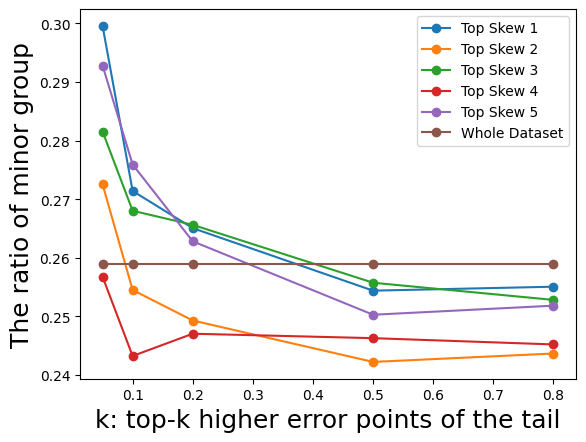

In [7]:
markers = ["o", "o", "o", "o", "o"]
for i in range(5):
    plt.plot(results[results["top_skew"] == i + 1]["score_ratio"], results[results["top_skew"] == i + 1]["tail_err_demo_ratio"], marker=markers[i], label=f"Top Skew {i + 1}")
plt.plot(results[results["top_skew"] == 1]["score_ratio"], results[results["top_skew"] == 1]["total_demo_ratio"], marker="o", label="Whole Dataset")
plt.ylabel("The ratio of minor group", fontsize=18)
plt.xlabel("k: top-k higher error points of the tail", fontsize=18)
plt.legend(fontsize=10)
# plt.savefig("diabetes_region.eps", format="eps")

In [29]:
# Model score = 0.71
results.groupby("top_skew").mean()[["total_avg_tail_score", "min_avg_tail_score", "maj_avg_tail_score"]]

,total_avg_tail_score,min_avg_tail_score,maj_avg_tail_score
top_skew,,,
1,0.653514,0.632362,0.655841
2,0.657878,0.658567,0.657799
3,0.655354,0.631232,0.657868
4,0.656826,0.641842,0.658318
5,0.638342,0.622613,0.640305
